In [2]:
print("branch test")

branch test


[Fold 1] Accuracy: 0.9713
[Fold 2] Accuracy: 0.9672
[Fold 3] Accuracy: 0.9733
[Fold 4] Accuracy: 0.9600
[Fold 5] Accuracy: 0.9774
[Fold 6] Accuracy: 0.9785
[Fold 7] Accuracy: 0.9692
[Fold 8] Accuracy: 0.9682
[Fold 9] Accuracy: 0.9692
[Fold 10] Accuracy: 0.9538

Mean K-Fold Accuracy: 0.9688061917548569
Classification Report (K-Fold):
               precision    recall  f1-score   support

           A       0.99      1.00      0.99       420
           B       0.99      1.00      0.99       420
           C       0.99      0.99      0.99       396
           D       0.98      0.99      0.98       394
           E       0.98      0.98      0.98       419
           F       0.99      0.97      0.98       414
           G       0.97      0.99      0.98       340
           H       0.98      0.98      0.98       298
           I       0.97      0.98      0.98       418
           J       0.99      0.98      0.98       420
           K       0.98      0.97      0.97       412
           L   

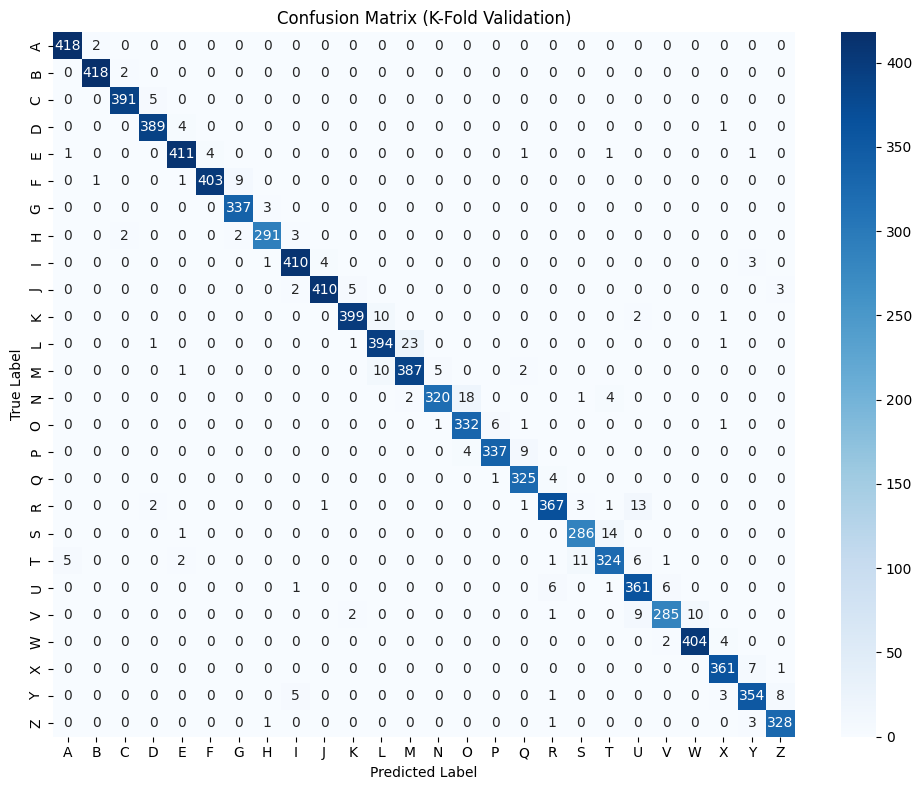


Final Test Accuracy: 0.9631314340435719
Classification Report (Test Data):
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       180
           B       0.99      0.99      0.99       180
           C       0.97      0.99      0.98       170
           D       0.98      0.98      0.98       168
           E       0.96      0.97      0.96       179
           F       0.97      0.98      0.97       178
           G       0.97      0.96      0.97       146
           H       0.96      0.91      0.93       127
           I       0.97      0.98      0.98       179
           J       0.98      0.95      0.97       180
           K       0.94      0.99      0.96       177
           L       0.98      0.96      0.97       180
           M       0.96      0.94      0.95       174
           N       0.95      0.93      0.94       148
           O       0.94      0.95      0.95       146
           P       0.95      0.98      0.97       150
    

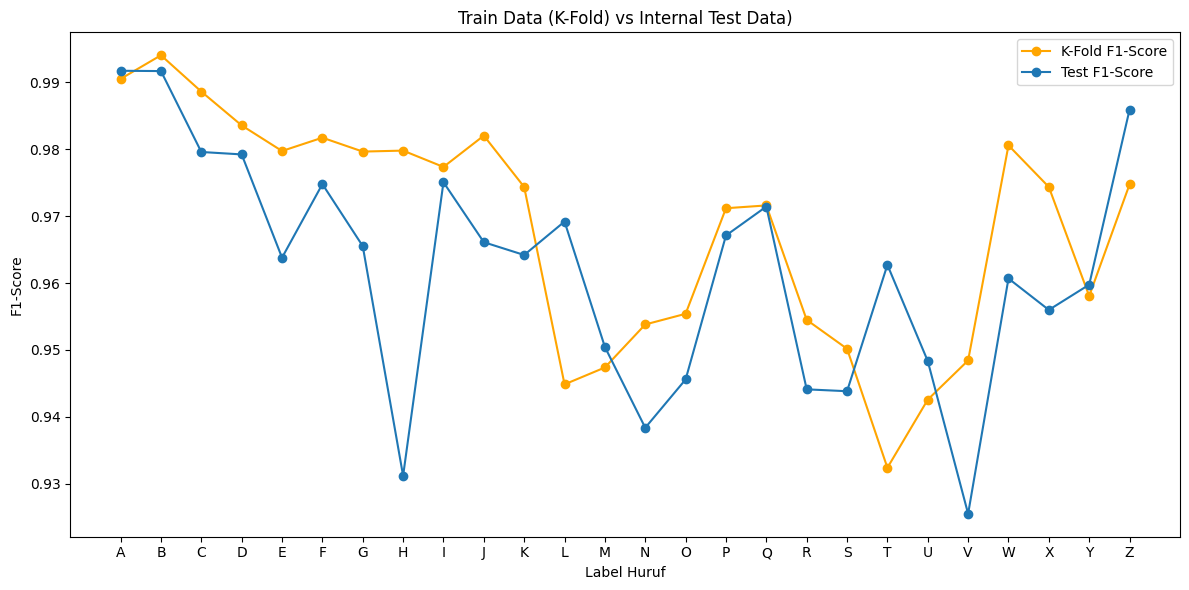

Model disimpan di: ../model-tuning/rf_model_kfold_tn1_1.p


In [8]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. LOAD & VALIDASI DATA TRAIN ---
data_dict = pickle.load(open('../train_data.pickle', 'rb'))
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}
class_names = [labels_dict[i] for i in sorted(labels_dict.keys())]

# --- 2. TRAIN TEST SPLIT 70:30 ---
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=42
)

# --- 3. K-FOLD VALIDATION (10 FOLD) + TRAINING WITH TUNING ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies, all_y_true, all_y_pred = [], [], []
final_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_full, y_train_full), 1):
    x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"[Fold {fold}] Accuracy: {acc:.4f}")
    final_model = model  # Model terakhir disimpan

# --- 4. EVALUASI K-FOLD ---
mean_kfold_acc = np.mean(accuracies)
print("\nMean K-Fold Accuracy:", mean_kfold_acc)

report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
report_kfold_text = classification_report(all_y_true, all_y_pred, target_names=class_names)
print("Classification Report (K-Fold):\n", report_kfold_text)

from sklearn.metrics import confusion_matrix

# Confusion Matrix dari seluruh prediksi K-Fold
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (K-Fold Validation)')
plt.tight_layout()
plt.show()

# --- 5. EVALUASI TEST DATA (INTERNAL SPLIT 30%) ---
y_test_pred = final_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("\nFinal Test Accuracy:", test_acc)
report_test = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred, target_names=class_names))

# --- 6. VISUALISASI F1-SCORE (TRAIN, TEST, K-FOLD) ---
f1_scores_train = [report_dict[cls]['f1-score'] for cls in class_names]
f1_scores_test = [report_test[cls]['f1-score'] for cls in class_names]

# Hitung F1 dari semua prediksi selama K-Fold
report_kfold = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
f1_scores_kfold = [report_kfold[cls]['f1-score'] for cls in class_names]

# Buat DataFrame untuk visualisasi
df_plot = pd.DataFrame({
    'Label': class_names,
    'Train F1-Score': f1_scores_train,
    'Test F1-Score': f1_scores_test,
    'K-Fold F1-Score': f1_scores_kfold
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Label'], df_plot['K-Fold F1-Score'], marker='o', label='K-Fold F1-Score', color='orange')
plt.plot(df_plot['Label'], df_plot['Test F1-Score'], marker='o', label='Test F1-Score', color='C0')
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score')
plt.title('Train Data (K-Fold) vs Internal Test Data)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. SIMPAN MODEL ---
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

i = 1
model_filename = os.path.join(model_folder, 'rf_model_kfold_tn1.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_kfold_tn1_{i}.p')
    i += 1

with open(model_filename, 'wb') as f:
    pickle.dump({'model': final_model}, f)
print(f"Model disimpan di: {model_filename}")


[Fold 1] Accuracy: 0.9651
[Fold 2] Accuracy: 0.9641
[Fold 3] Accuracy: 0.9651
[Fold 4] Accuracy: 0.9579
[Fold 5] Accuracy: 0.9713
[Fold 6] Accuracy: 0.9703
[Fold 7] Accuracy: 0.9671
[Fold 8] Accuracy: 0.9661
[Fold 9] Accuracy: 0.9641
[Fold 10] Accuracy: 0.9507

Mean K-Fold Accuracy: 0.9641895435160321
Classification Report (K-Fold):
               precision    recall  f1-score   support

           A       0.97      1.00      0.98       420
           B       0.99      1.00      0.99       420
           C       0.99      0.99      0.99       396
           D       0.97      0.99      0.98       394
           E       0.98      0.97      0.98       419
           F       0.99      0.98      0.98       414
           G       0.97      0.99      0.98       340
           H       0.98      0.98      0.98       298
           I       0.97      0.98      0.98       418
           J       0.99      0.96      0.98       420
           K       0.97      0.96      0.96       412
           L   

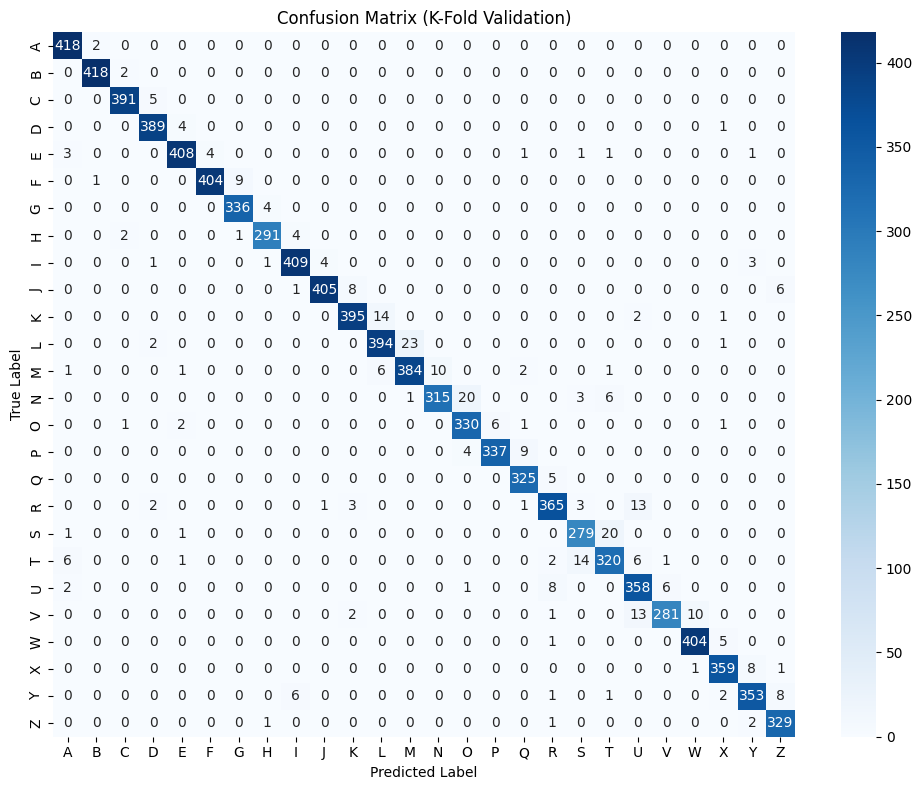


Final Test Accuracy: 0.9578644960497965
Classification Report (Test Data):
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       180
           B       0.99      0.99      0.99       180
           C       0.97      0.99      0.98       170
           D       0.98      0.98      0.98       168
           E       0.96      0.97      0.96       179
           F       0.97      0.97      0.97       178
           G       0.97      0.96      0.96       146
           H       0.96      0.90      0.93       127
           I       0.96      0.98      0.97       179
           J       0.98      0.95      0.96       180
           K       0.95      0.98      0.96       177
           L       0.98      0.96      0.97       180
           M       0.96      0.93      0.94       174
           N       0.94      0.92      0.93       148
           O       0.93      0.96      0.94       146
           P       0.95      0.97      0.96       150
    

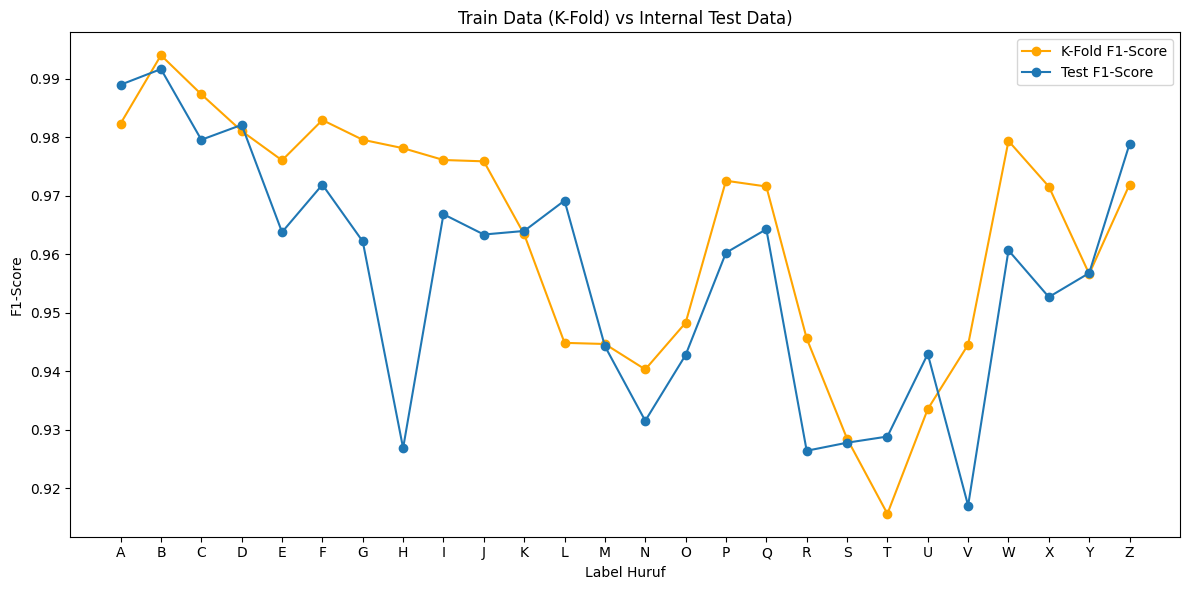

Model disimpan di: ../model-tuning/rf_model_kfold_tn1_2.p


In [9]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. LOAD & VALIDASI DATA TRAIN ---
data_dict = pickle.load(open('../train_data.pickle', 'rb'))
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}
class_names = [labels_dict[i] for i in sorted(labels_dict.keys())]

# --- 2. TRAIN TEST SPLIT 70:30 ---
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=42
)

# --- 3. K-FOLD VALIDATION (10 FOLD) + TRAINING WITH TUNING ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies, all_y_true, all_y_pred = [], [], []
final_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_full, y_train_full), 1):
    x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = RandomForestClassifier(
        n_estimators=400,
        max_depth=30,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"[Fold {fold}] Accuracy: {acc:.4f}")
    final_model = model  # Model terakhir disimpan

# --- 4. EVALUASI K-FOLD ---
mean_kfold_acc = np.mean(accuracies)
print("\nMean K-Fold Accuracy:", mean_kfold_acc)

report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
report_kfold_text = classification_report(all_y_true, all_y_pred, target_names=class_names)
print("Classification Report (K-Fold):\n", report_kfold_text)

from sklearn.metrics import confusion_matrix

# Confusion Matrix dari seluruh prediksi K-Fold
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (K-Fold Validation)')
plt.tight_layout()
plt.show()

# --- 5. EVALUASI TEST DATA (INTERNAL SPLIT 30%) ---
y_test_pred = final_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("\nFinal Test Accuracy:", test_acc)
report_test = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred, target_names=class_names))

# --- 6. VISUALISASI F1-SCORE (TRAIN, TEST, K-FOLD) ---
f1_scores_train = [report_dict[cls]['f1-score'] for cls in class_names]
f1_scores_test = [report_test[cls]['f1-score'] for cls in class_names]

# Hitung F1 dari semua prediksi selama K-Fold
report_kfold = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
f1_scores_kfold = [report_kfold[cls]['f1-score'] for cls in class_names]

# Buat DataFrame untuk visualisasi
df_plot = pd.DataFrame({
    'Label': class_names,
    'Train F1-Score': f1_scores_train,
    'Test F1-Score': f1_scores_test,
    'K-Fold F1-Score': f1_scores_kfold
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Label'], df_plot['K-Fold F1-Score'], marker='o', label='K-Fold F1-Score', color='orange')
plt.plot(df_plot['Label'], df_plot['Test F1-Score'], marker='o', label='Test F1-Score', color='C0')
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score')
plt.title('Train Data (K-Fold) vs Internal Test Data)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. SIMPAN MODEL ---
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

i = 1
model_filename = os.path.join(model_folder, 'rf_model_kfold_tn1.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_kfold_tn1_{i}.p')
    i += 1

with open(model_filename, 'wb') as f:
    pickle.dump({'model': final_model}, f)
print(f"Model disimpan di: {model_filename}")


[Fold 1] Accuracy: 0.9713
[Fold 2] Accuracy: 0.9682
[Fold 3] Accuracy: 0.9713
[Fold 4] Accuracy: 0.9610
[Fold 5] Accuracy: 0.9805
[Fold 6] Accuracy: 0.9774
[Fold 7] Accuracy: 0.9733
[Fold 8] Accuracy: 0.9713
[Fold 9] Accuracy: 0.9702
[Fold 10] Accuracy: 0.9548

Mean K-Fold Accuracy: 0.9699353446006423
Classification Report (K-Fold):
               precision    recall  f1-score   support

           A       0.99      1.00      0.99       420
           B       0.99      1.00      0.99       420
           C       0.99      0.99      0.99       396
           D       0.97      0.99      0.98       394
           E       0.98      0.97      0.98       419
           F       0.98      0.97      0.98       414
           G       0.97      0.99      0.98       340
           H       0.99      0.96      0.98       298
           I       0.97      0.98      0.97       418
           J       0.99      0.99      0.99       420
           K       0.97      0.97      0.97       412
           L   

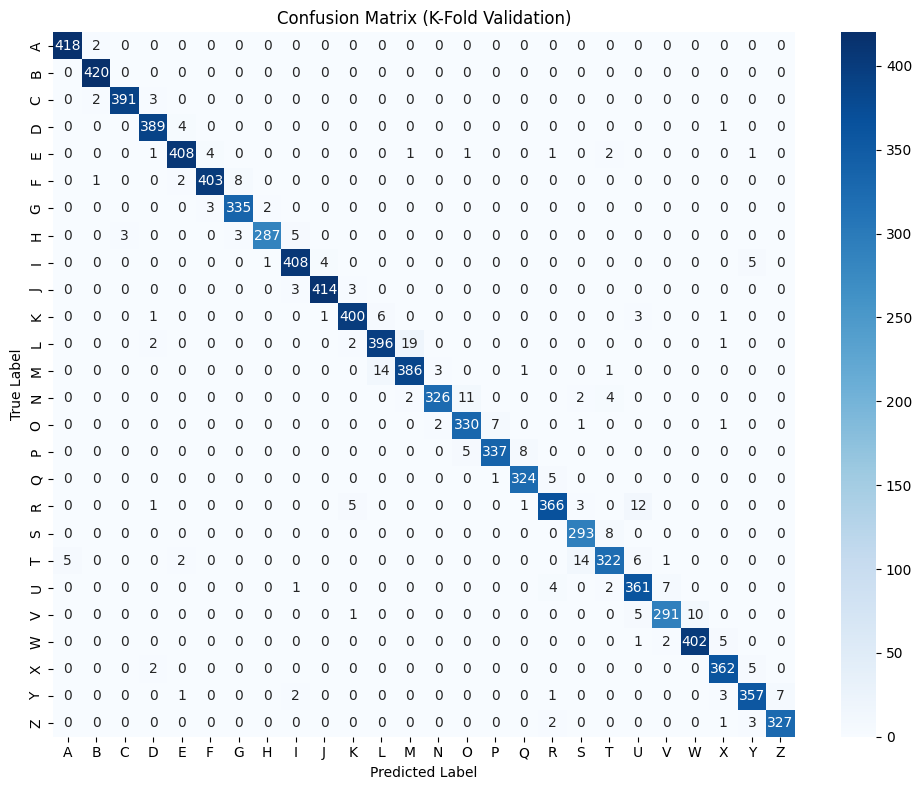


Final Test Accuracy: 0.9619344026813502
Classification Report (Test Data):
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       180
           B       0.99      0.99      0.99       180
           C       0.97      0.98      0.98       170
           D       0.99      0.98      0.99       168
           E       0.96      0.97      0.96       179
           F       0.97      0.99      0.98       178
           G       0.98      0.96      0.97       146
           H       0.97      0.91      0.93       127
           I       0.97      0.99      0.98       179
           J       0.99      0.96      0.97       180
           K       0.94      0.99      0.96       177
           L       0.97      0.96      0.96       180
           M       0.96      0.91      0.94       174
           N       0.94      0.92      0.93       148
           O       0.93      0.95      0.94       146
           P       0.95      0.98      0.97       150
    

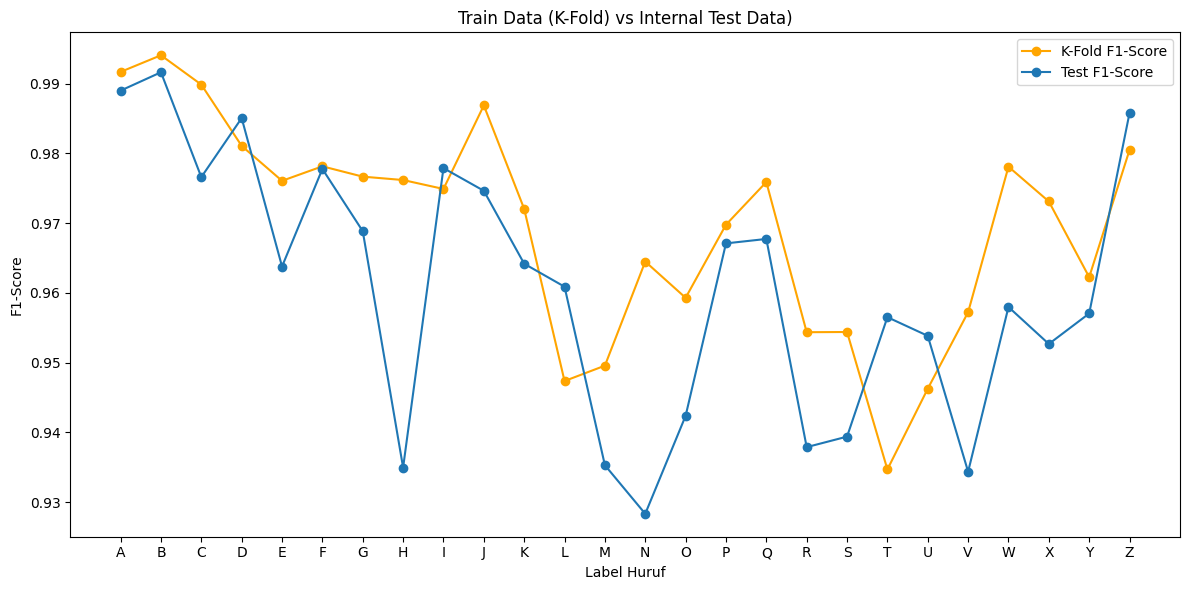

Model disimpan di: ../model-tuning/rf_model_kfold_tn1_3.p


In [10]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. LOAD & VALIDASI DATA TRAIN ---
data_dict = pickle.load(open('../train_data.pickle', 'rb'))
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}
class_names = [labels_dict[i] for i in sorted(labels_dict.keys())]

# --- 2. TRAIN TEST SPLIT 70:30 ---
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=42
)

# --- 3. K-FOLD VALIDATION (10 FOLD) + TRAINING WITH TUNING ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies, all_y_true, all_y_pred = [], [], []
final_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_full, y_train_full), 1):
    x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = RandomForestClassifier(
        n_estimators=600,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.5,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"[Fold {fold}] Accuracy: {acc:.4f}")
    final_model = model  # Model terakhir disimpan

# --- 4. EVALUASI K-FOLD ---
mean_kfold_acc = np.mean(accuracies)
print("\nMean K-Fold Accuracy:", mean_kfold_acc)

report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
report_kfold_text = classification_report(all_y_true, all_y_pred, target_names=class_names)
print("Classification Report (K-Fold):\n", report_kfold_text)

from sklearn.metrics import confusion_matrix

# Confusion Matrix dari seluruh prediksi K-Fold
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (K-Fold Validation)')
plt.tight_layout()
plt.show()

# --- 5. EVALUASI TEST DATA (INTERNAL SPLIT 30%) ---
y_test_pred = final_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("\nFinal Test Accuracy:", test_acc)
report_test = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred, target_names=class_names))

# --- 6. VISUALISASI F1-SCORE (TRAIN, TEST, K-FOLD) ---
f1_scores_train = [report_dict[cls]['f1-score'] for cls in class_names]
f1_scores_test = [report_test[cls]['f1-score'] for cls in class_names]

# Hitung F1 dari semua prediksi selama K-Fold
report_kfold = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
f1_scores_kfold = [report_kfold[cls]['f1-score'] for cls in class_names]

# Buat DataFrame untuk visualisasi
df_plot = pd.DataFrame({
    'Label': class_names,
    'Train F1-Score': f1_scores_train,
    'Test F1-Score': f1_scores_test,
    'K-Fold F1-Score': f1_scores_kfold
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Label'], df_plot['K-Fold F1-Score'], marker='o', label='K-Fold F1-Score', color='orange')
plt.plot(df_plot['Label'], df_plot['Test F1-Score'], marker='o', label='Test F1-Score', color='C0')
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score')
plt.title('Train Data (K-Fold) vs Internal Test Data)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. SIMPAN MODEL ---
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

i = 1
model_filename = os.path.join(model_folder, 'rf_model_kfold_tn1.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_kfold_tn1_{i}.p')
    i += 1

with open(model_filename, 'wb') as f:
    pickle.dump({'model': final_model}, f)
print(f"Model disimpan di: {model_filename}")


[Fold 1] Accuracy: 0.9754
[Fold 2] Accuracy: 0.9703
[Fold 3] Accuracy: 0.9733
[Fold 4] Accuracy: 0.9621
[Fold 5] Accuracy: 0.9774
[Fold 6] Accuracy: 0.9815
[Fold 7] Accuracy: 0.9723
[Fold 8] Accuracy: 0.9723
[Fold 9] Accuracy: 0.9774
[Fold 10] Accuracy: 0.9600

Mean K-Fold Accuracy: 0.9721930184804928
Classification Report (K-Fold):
               precision    recall  f1-score   support

           A       0.99      1.00      0.99       420
           B       0.99      1.00      1.00       420
           C       0.99      0.99      0.99       396
           D       0.98      0.99      0.98       394
           E       0.97      0.98      0.97       419
           F       0.98      0.97      0.98       414
           G       0.97      0.99      0.98       340
           H       0.99      0.97      0.98       298
           I       0.98      0.98      0.98       418
           J       0.99      0.99      0.99       420
           K       0.98      0.98      0.98       412
           L   

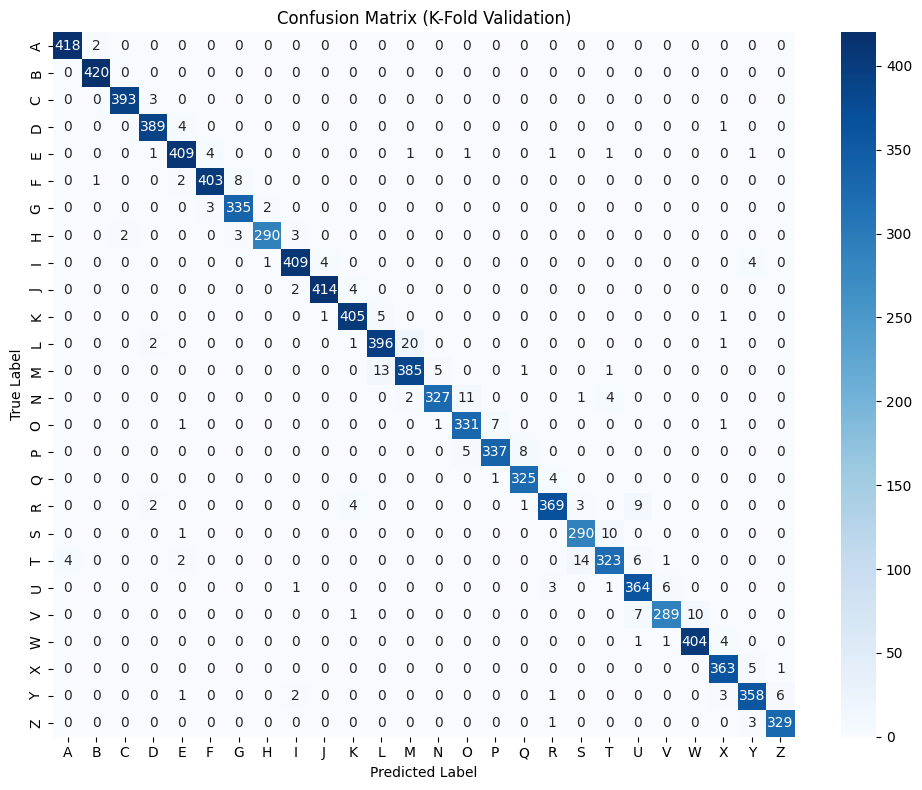


Final Test Accuracy: 0.9640890591333493
Classification Report (Test Data):
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       180
           B       0.99      0.99      0.99       180
           C       0.97      0.99      0.98       170
           D       0.98      0.98      0.98       168
           E       0.96      0.97      0.96       179
           F       0.97      0.98      0.97       178
           G       0.98      0.96      0.97       146
           H       0.97      0.91      0.93       127
           I       0.96      0.99      0.98       179
           J       0.99      0.97      0.98       180
           K       0.95      0.99      0.97       177
           L       0.97      0.96      0.96       180
           M       0.96      0.93      0.94       174
           N       0.95      0.92      0.93       148
           O       0.95      0.96      0.95       146
           P       0.96      0.99      0.97       150
    

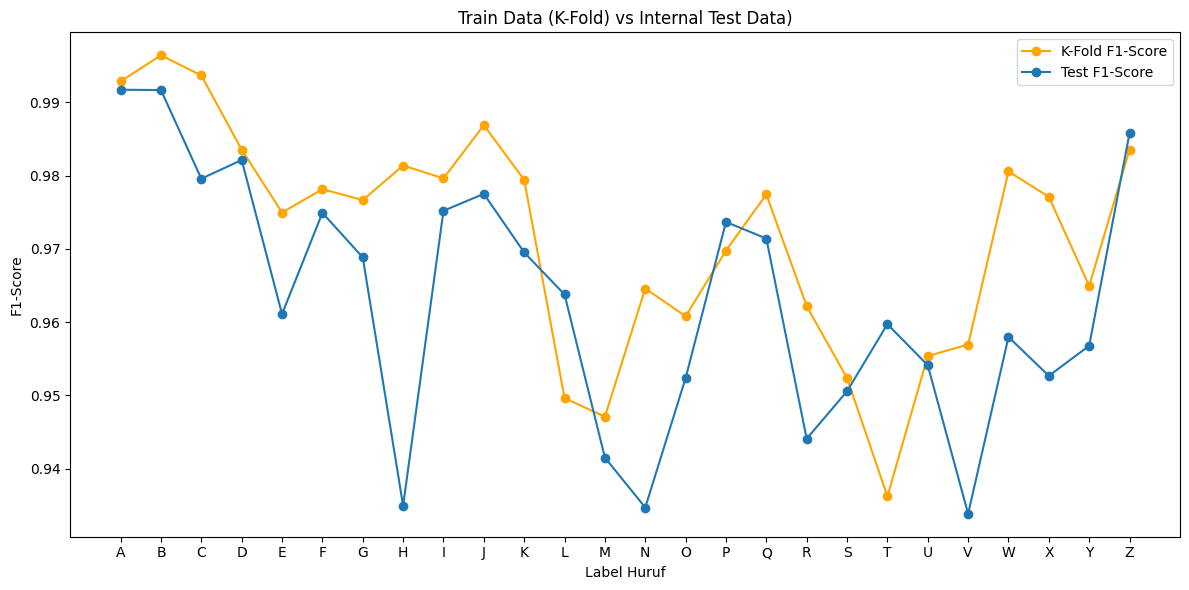

Model disimpan di: ../model-tuning/rf_model_kfold_tn1_4.p


In [11]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. LOAD & VALIDASI DATA TRAIN ---
data_dict = pickle.load(open('../train_data.pickle', 'rb'))
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}
class_names = [labels_dict[i] for i in sorted(labels_dict.keys())]

# --- 2. TRAIN TEST SPLIT 70:30 ---
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=42
)

# --- 3. K-FOLD VALIDATION (10 FOLD) + TRAINING WITH TUNING ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies, all_y_true, all_y_pred = [], [], []
final_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_full, y_train_full), 1):
    x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = RandomForestClassifier(
        n_estimators=1000,          # lebih banyak pohon = lebih stabil
        max_depth=25,               # cukup dalam, tapi tidak terlalu dalam
        min_samples_split=2,        # mengizinkan lebih banyak percabangan
        min_samples_leaf=1,         # leaf paling kecil
        max_features=0.3,           # batasi fitur yang dipilih → kurangi korelasi antar pohon
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"[Fold {fold}] Accuracy: {acc:.4f}")
    final_model = model  # Model terakhir disimpan

# --- 4. EVALUASI K-FOLD ---
mean_kfold_acc = np.mean(accuracies)
print("\nMean K-Fold Accuracy:", mean_kfold_acc)

report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
report_kfold_text = classification_report(all_y_true, all_y_pred, target_names=class_names)
print("Classification Report (K-Fold):\n", report_kfold_text)

from sklearn.metrics import confusion_matrix

# Confusion Matrix dari seluruh prediksi K-Fold
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (K-Fold Validation)')
plt.tight_layout()
plt.show()

# --- 5. EVALUASI TEST DATA (INTERNAL SPLIT 30%) ---
y_test_pred = final_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("\nFinal Test Accuracy:", test_acc)
report_test = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred, target_names=class_names))

# --- 6. VISUALISASI F1-SCORE (TRAIN, TEST, K-FOLD) ---
f1_scores_train = [report_dict[cls]['f1-score'] for cls in class_names]
f1_scores_test = [report_test[cls]['f1-score'] for cls in class_names]

# Hitung F1 dari semua prediksi selama K-Fold
report_kfold = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
f1_scores_kfold = [report_kfold[cls]['f1-score'] for cls in class_names]

# Buat DataFrame untuk visualisasi
df_plot = pd.DataFrame({
    'Label': class_names,
    'Train F1-Score': f1_scores_train,
    'Test F1-Score': f1_scores_test,
    'K-Fold F1-Score': f1_scores_kfold
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Label'], df_plot['K-Fold F1-Score'], marker='o', label='K-Fold F1-Score', color='orange')
plt.plot(df_plot['Label'], df_plot['Test F1-Score'], marker='o', label='Test F1-Score', color='C0')
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score')
plt.title('Train Data (K-Fold) vs Internal Test Data)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. SIMPAN MODEL ---
model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

i = 1
model_filename = os.path.join(model_folder, 'rf_model_kfold_tn1.p')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_kfold_tn1_{i}.p')
    i += 1

with open(model_filename, 'wb') as f:
    pickle.dump({'model': final_model}, f)
print(f"Model disimpan di: {model_filename}")


[Fold 1] Accuracy: 0.9754
[Fold 2] Accuracy: 0.9703
[Fold 3] Accuracy: 0.9733
[Fold 4] Accuracy: 0.9621
[Fold 5] Accuracy: 0.9774
[Fold 6] Accuracy: 0.9815
[Fold 7] Accuracy: 0.9723
[Fold 8] Accuracy: 0.9723
[Fold 9] Accuracy: 0.9774
[Fold 10] Accuracy: 0.9600

Mean K-Fold Accuracy: 0.9721930184804928
Classification Report (K-Fold):
               precision    recall  f1-score   support

           A       0.99      1.00      0.99       420
           B       0.99      1.00      1.00       420
           C       0.99      0.99      0.99       396
           D       0.98      0.99      0.98       394
           E       0.97      0.98      0.97       419
           F       0.98      0.97      0.98       414
           G       0.97      0.99      0.98       340
           H       0.99      0.97      0.98       298
           I       0.98      0.98      0.98       418
           J       0.99      0.99      0.99       420
           K       0.98      0.98      0.98       412
           L   

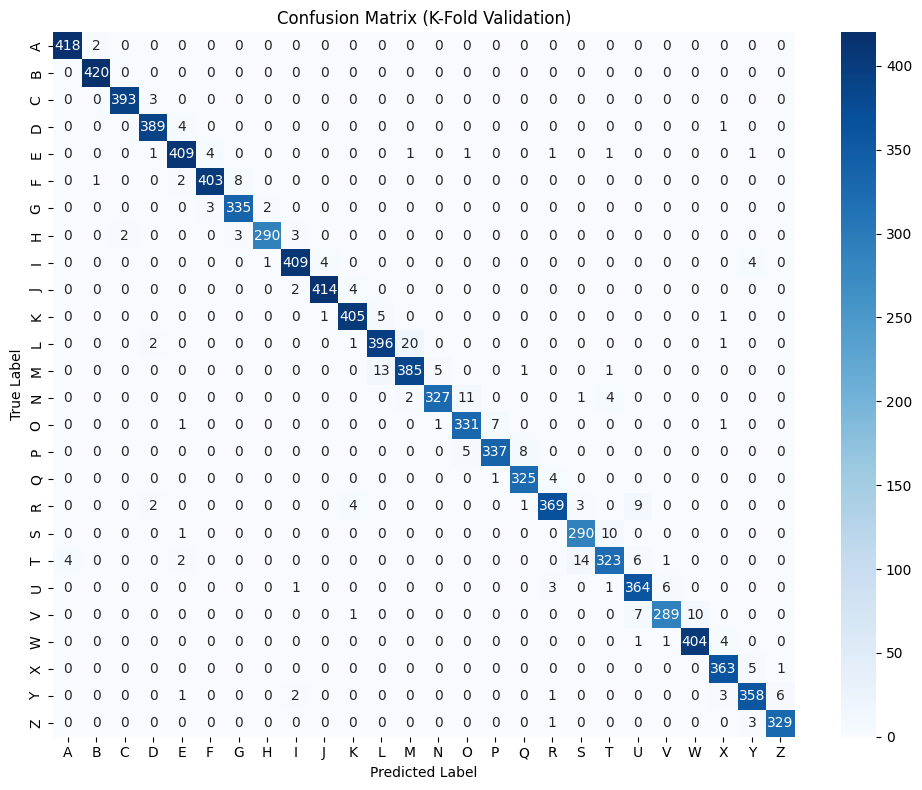


Final Test Accuracy: 0.9640890591333493
Classification Report (Test Data):
               precision    recall  f1-score   support

           A       0.98      1.00      0.99       180
           B       0.99      0.99      0.99       180
           C       0.97      0.99      0.98       170
           D       0.98      0.98      0.98       168
           E       0.96      0.97      0.96       179
           F       0.97      0.98      0.97       178
           G       0.98      0.96      0.97       146
           H       0.97      0.91      0.93       127
           I       0.96      0.99      0.98       179
           J       0.99      0.97      0.98       180
           K       0.95      0.99      0.97       177
           L       0.97      0.96      0.96       180
           M       0.96      0.93      0.94       174
           N       0.95      0.92      0.93       148
           O       0.95      0.96      0.95       146
           P       0.96      0.99      0.97       150
    

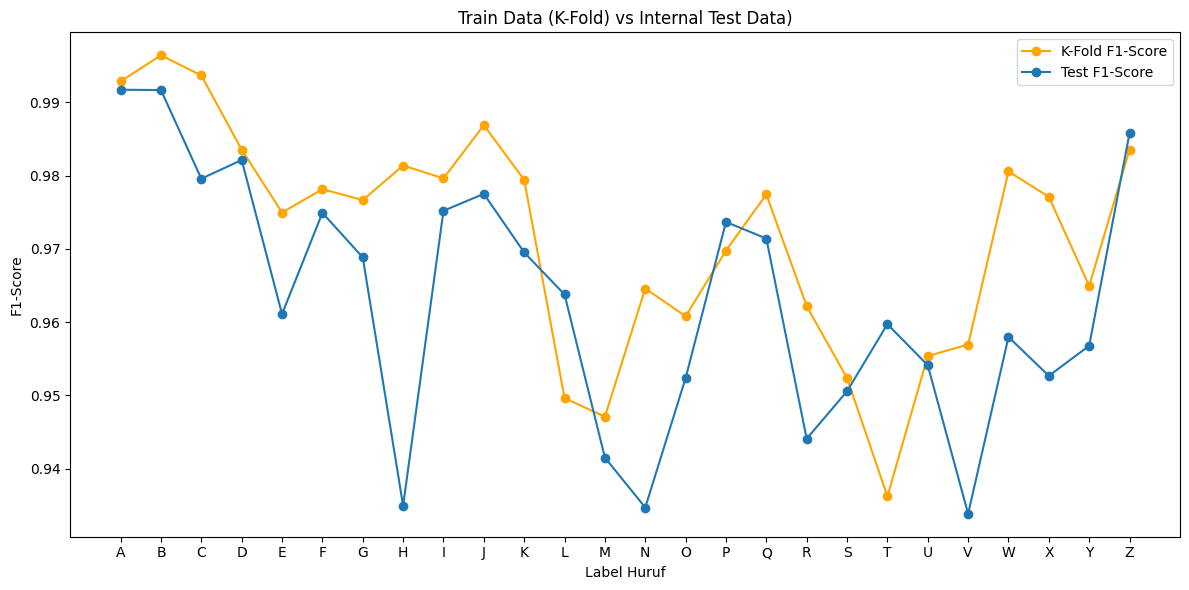

Model dikompres dan disimpan di: ../model-tuning/rf_model_kfold_tn1.joblib


In [12]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report




# --- 1. LOAD & VALIDASI DATA TRAIN ---
data_dict = pickle.load(open('../train_data.pickle', 'rb'))
valid_data = [sample for sample in data_dict['data'] if len(sample) == 42]
data = np.array(valid_data)
labels = np.array(data_dict['labels'][:len(valid_data)])
labels_dict = {i: label for i, label in enumerate(sorted(set(labels)))}
class_names = [labels_dict[i] for i in sorted(labels_dict.keys())]

# --- 2. TRAIN TEST SPLIT 70:30 ---
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=42
)

# --- 3. K-FOLD VALIDATION (10 FOLD) + TRAINING WITH TUNING ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies, all_y_true, all_y_pred = [], [], []
final_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_full, y_train_full), 1):
    x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = RandomForestClassifier(
        n_estimators=1000,          # lebih banyak pohon = lebih stabil
        max_depth=25,               # cukup dalam, tapi tidak terlalu dalam
        min_samples_split=2,        # mengizinkan lebih banyak percabangan
        min_samples_leaf=1,         # leaf paling kecil
        max_features=0.3,           # batasi fitur yang dipilih → kurangi korelasi antar pohon
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"[Fold {fold}] Accuracy: {acc:.4f}")
    final_model = model  # Model terakhir disimpan

# --- 4. EVALUASI K-FOLD ---
mean_kfold_acc = np.mean(accuracies)
print("\nMean K-Fold Accuracy:", mean_kfold_acc)

report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
report_kfold_text = classification_report(all_y_true, all_y_pred, target_names=class_names)
print("Classification Report (K-Fold):\n", report_kfold_text)

from sklearn.metrics import confusion_matrix

# Confusion Matrix dari seluruh prediksi K-Fold
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (K-Fold Validation)')
plt.tight_layout()
plt.show()

# --- 5. EVALUASI TEST DATA (INTERNAL SPLIT 30%) ---
y_test_pred = final_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("\nFinal Test Accuracy:", test_acc)
report_test = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred, target_names=class_names))

# --- 6. VISUALISASI F1-SCORE (TRAIN, TEST, K-FOLD) ---
f1_scores_train = [report_dict[cls]['f1-score'] for cls in class_names]
f1_scores_test = [report_test[cls]['f1-score'] for cls in class_names]

# Hitung F1 dari semua prediksi selama K-Fold
report_kfold = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
f1_scores_kfold = [report_kfold[cls]['f1-score'] for cls in class_names]

# Buat DataFrame untuk visualisasi
df_plot = pd.DataFrame({
    'Label': class_names,
    'Train F1-Score': f1_scores_train,
    'Test F1-Score': f1_scores_test,
    'K-Fold F1-Score': f1_scores_kfold
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Label'], df_plot['K-Fold F1-Score'], marker='o', label='K-Fold F1-Score', color='orange')
plt.plot(df_plot['Label'], df_plot['Test F1-Score'], marker='o', label='Test F1-Score', color='C0')
plt.xlabel('Label Huruf')
plt.ylabel('F1-Score')
plt.title('Train Data (K-Fold) vs Internal Test Data)')
plt.legend()
plt.tight_layout()
plt.show()


# --- 7. SIMPAN MODEL MENGGUNAKAN JOBLIB (DENGAN KOMPRESI) ---

import joblib

model_folder = '../model-tuning/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

i = 1
model_filename = os.path.join(model_folder, 'rf_model_kfold_tn1.joblib')
while os.path.exists(model_filename):
    model_filename = os.path.join(model_folder, f'rf_model_kfold_tn1_{i}.joblib')
    i += 1

joblib.dump(final_model, model_filename, compress=3)
print(f"Model dikompres dan disimpan di: {model_filename}")
